## Промышленность — задача проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

### Данные

[final_steel.zip](https://s3-us-west-2.amazonaws.com/secure.notion-static.com/f3fbea3a-263d-4e1c-babd-0bf07920c911/final_steel.zip)

Данные также находятся в тренажёре, в папке `/datasets/final_steel/`.

### План работы
1. Подготовка и анализ данных
* пропуски и дубликаты. 

    Заполним пропуски "0" в данных: 

- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);

- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).


* выбросы
* формат данных 

Температура плавления: 1450—1520 °C. Удалим все, что меньше 1450. 

2. Предобработка данных
* проверка на мультиколлинеарность
* выделение признаков и целевого признака 
* маштабирование
* разделение на обучающую и тестовую выборку 

3. Обучение моделей
* выбор нескольких моделей 
* подбор гиперпараметров
* обучение на обучающей выборке
* проверка на тестовой 

4. Вывод

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor


Загрузим данные 

In [2]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768


count    14876.000000
mean         0.670441
std          0.408159
min          0.030002
25%          0.395297
50%          0.555517
75%          0.857034
max          3.731596
Name: active_power, dtype: float64

<AxesSubplot:>

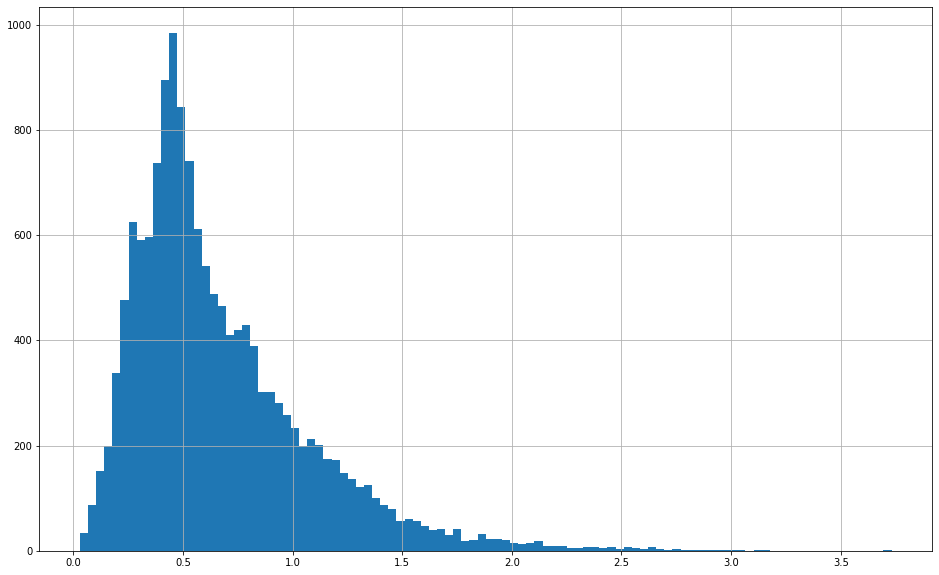

In [3]:
data_arc.info()
display(data_arc)
data_arc=data_arc.rename({'Начало нагрева дугой': 'start_arc_heating', 
                          'Конец нагрева дугой': 'end_arc_heating', 
                          'Активная мощность': 'active_power',
                          'Реактивная мощность': 'reactive_power'}, axis='columns')
display(data_arc['active_power'].describe())
data_arc['active_power'].hist(bins=100, figsize=(16,10))


count    14876.000000
mean         0.452592
std          5.878702
min       -715.504924
25%          0.290991
50%          0.415962
75%          0.637371
max          2.676388
Name: reactive_power, dtype: float64

<AxesSubplot:>

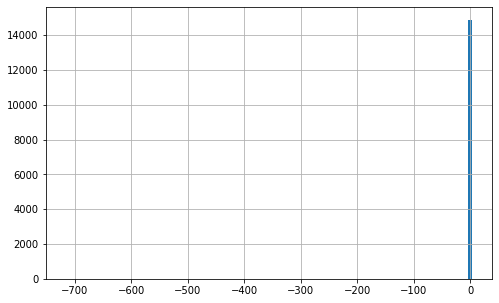

In [4]:
display(data_arc['reactive_power'].describe())
data_arc['reactive_power'].hist(bins=100, figsize=(8,5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


array([[<AxesSubplot:title={'center':'key'}>,
        <AxesSubplot:title={'center':'Bulk 1'}>,
        <AxesSubplot:title={'center':'Bulk 2'}>,
        <AxesSubplot:title={'center':'Bulk 3'}>],
       [<AxesSubplot:title={'center':'Bulk 4'}>,
        <AxesSubplot:title={'center':'Bulk 5'}>,
        <AxesSubplot:title={'center':'Bulk 6'}>,
        <AxesSubplot:title={'center':'Bulk 7'}>],
       [<AxesSubplot:title={'center':'Bulk 8'}>,
        <AxesSubplot:title={'center':'Bulk 9'}>,
        <AxesSubplot:title={'center':'Bulk 10'}>,
        <AxesSubplot:title={'center':'Bulk 11'}>],
       [<AxesSubplot:title={'center':'Bulk 12'}>,
        <AxesSubplot:title={'center':'Bulk 13'}>,
        <AxesSubplot:title={'center':'Bulk 14'}>,
        <AxesSubplot:title={'center':'Bulk 15'}>]], dtype=object)

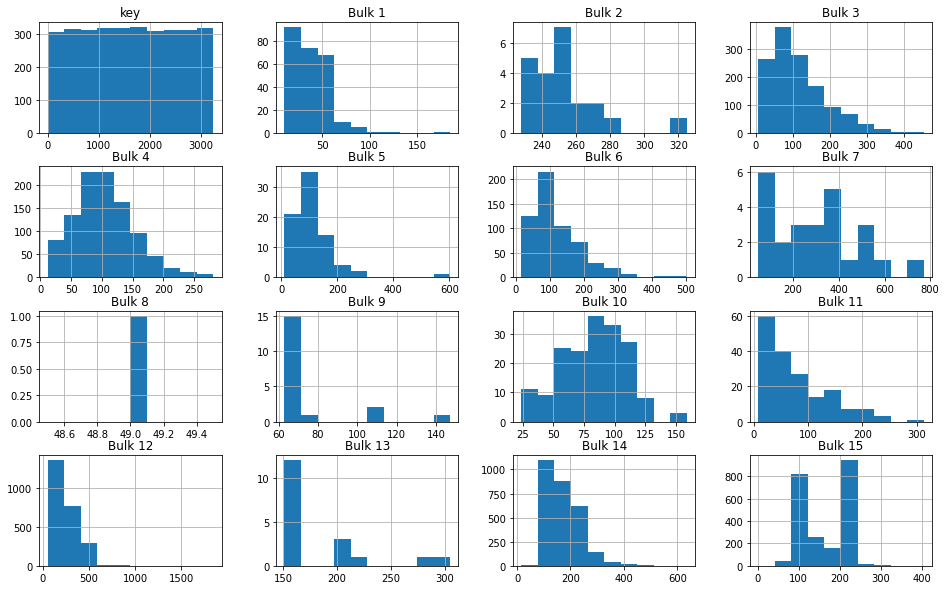

In [5]:
data_bulk.info()
display(data_bulk)
display(data_bulk.describe())
data_bulk.hist(bins=10, figsize=(16,10))

In [6]:
data_bulk_time.info()
display(data_bulk_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,2019-08-31 22:51:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 22:46:52,NaN,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaN,NaN,2019-08-31 23:39:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 23:33:09,NaN,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:51:58,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:39:41,NaN,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-01 03:12:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 02:41:27,2019-09-01 02:41:27


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: gas_1, dtype: float64

<AxesSubplot:>

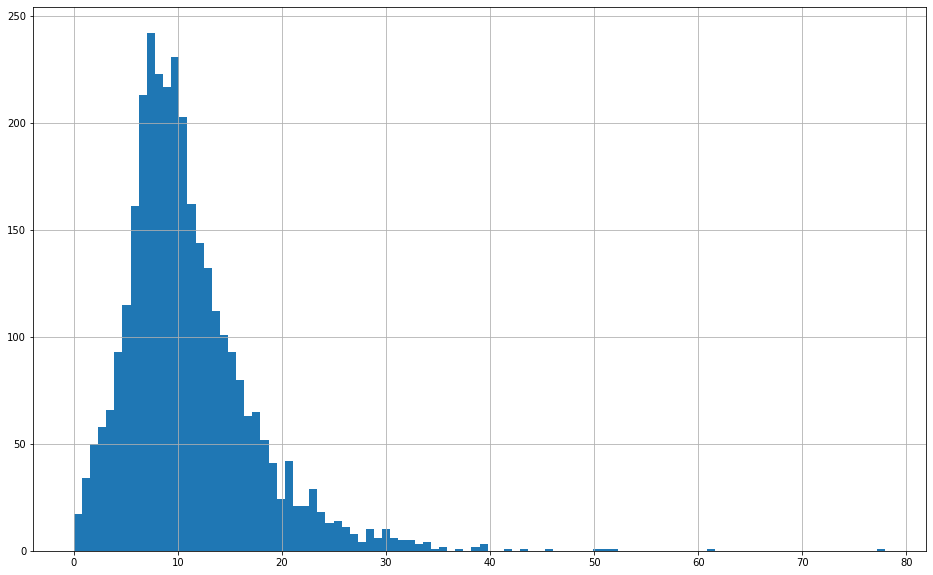

In [7]:
data_gas.info()
display(data_gas)
data_gas=data_gas.rename({'Газ 1': 'gas_1'}, axis='columns')
display(data_gas['gas_1'].describe())
data_gas['gas_1'].hist(bins=100, figsize=(16,10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


count    13006.000000
mean      1591.840920
std         21.375851
min       1191.000000
25%       1581.000000
50%       1591.000000
75%       1601.000000
max       1705.000000
Name: temp, dtype: float64

(3216,)

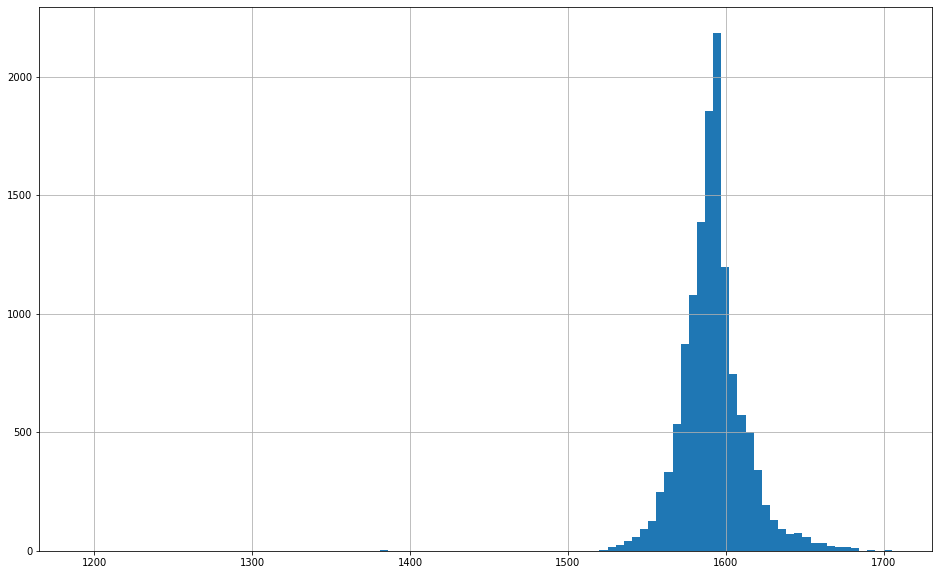

In [8]:
data_temp.info()
display(data_temp.head(30))
data_temp=data_temp.rename({'Температура': 'temp', 
                          'Время замера': 'm_time'}, axis='columns')
display(data_temp['temp'].describe())
data_temp['temp'].hist(bins=100, figsize=(16,10))
data_temp['key'].unique().shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


array([[<AxesSubplot:title={'center':'key'}>,
        <AxesSubplot:title={'center':'Wire 1'}>,
        <AxesSubplot:title={'center':'Wire 2'}>],
       [<AxesSubplot:title={'center':'Wire 3'}>,
        <AxesSubplot:title={'center':'Wire 4'}>,
        <AxesSubplot:title={'center':'Wire 5'}>],
       [<AxesSubplot:title={'center':'Wire 6'}>,
        <AxesSubplot:title={'center':'Wire 7'}>,
        <AxesSubplot:title={'center':'Wire 8'}>],
       [<AxesSubplot:title={'center':'Wire 9'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

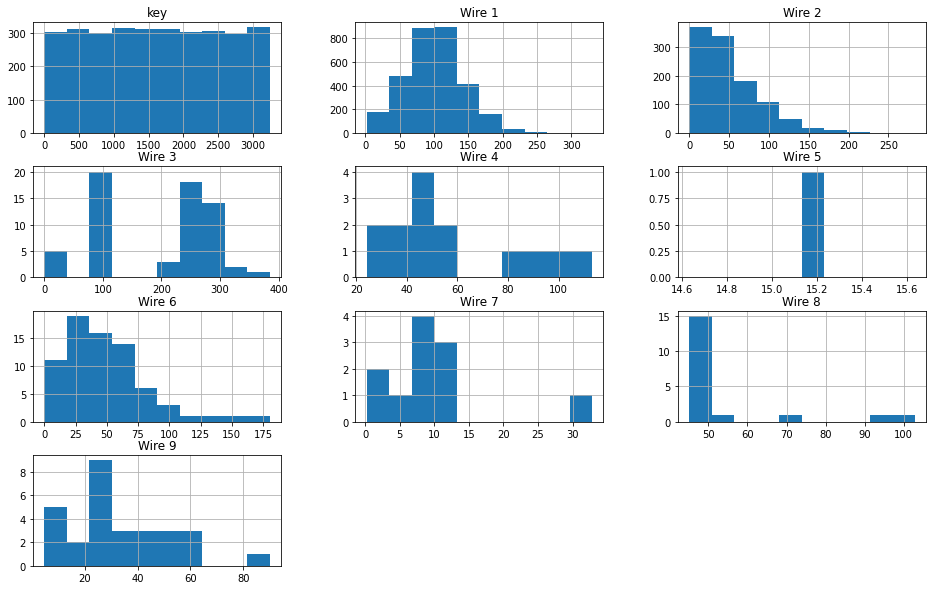

In [9]:
data_wire.info()
display(data_wire)
display(data_wire.describe())
data_wire.hist(bins=10, figsize=(16,10))

Заметим, что data_wire 'Wire 5' содержит только одно не пустое значение. удалим этот столбец

In [10]:
data_wire=data_wire.drop(columns='Wire 5')

In [11]:
data_wire_time.info()
display(data_wire_time)
display(data_wire_time.describe())
data_wire_time.info()
data_wire_time=data_wire_time.drop(columns='Wire 5')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-08-31 22:50:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-08-31 23:38:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-01 01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-01 03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [12]:
data_bulk=data_bulk.fillna(0)
data_bulk_time=data_bulk_time.fillna(0)
data_wire=data_wire.fillna(0)
data_wire_time=data_wire_time.fillna(0)

Удалим данные где reactive_power <= 0

In [13]:
data_arc = data_arc.query('reactive_power > 0')

In [14]:
data_arc['start_arc_heating'] = pd.to_datetime(data_arc['start_arc_heating'])
data_arc['end_arc_heating'] = pd.to_datetime(data_arc['end_arc_heating'])

In [15]:
data_arc['total_power'] = np.sqrt(data_arc['active_power'] + data_arc['reactive_power'])
data_arc['duration_arc'] = (data_arc['end_arc_heating'] - data_arc['start_arc_heating']).astype('timedelta64[s]')
data_arc['energy'] = data_arc['total_power'] * data_arc['duration_arc']


In [16]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14875 entries, 0 to 14875
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   key                14875 non-null  int64         
 1   start_arc_heating  14875 non-null  datetime64[ns]
 2   end_arc_heating    14875 non-null  datetime64[ns]
 3   active_power       14875 non-null  float64       
 4   reactive_power     14875 non-null  float64       
 5   total_power        14875 non-null  float64       
 6   duration_arc       14875 non-null  float64       
 7   energy             14875 non-null  float64       
dtypes: datetime64[ns](2), float64(5), int64(1)
memory usage: 1.0 MB


In [17]:
f_count = {
    'key'            : 'count', 
    'start_arc_heating' : 'first',
    'end_arc_heating': 'last',
    'active_power'   : 'mean',
    'reactive_power' : 'mean',
    'total_power'    : 'mean',
    'duration_arc'   : 'sum',
    'energy'         : 'sum'
}



In [18]:
data_arc_key = data_arc.groupby('key').agg(f_count).rename(columns={'key':'count'})

In [19]:
data_arc_key.info()
display(data_arc_key)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 1 to 3241
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   count              3214 non-null   int64         
 1   start_arc_heating  3214 non-null   datetime64[ns]
 2   end_arc_heating    3214 non-null   datetime64[ns]
 3   active_power       3214 non-null   float64       
 4   reactive_power     3214 non-null   float64       
 5   total_power        3214 non-null   float64       
 6   duration_arc       3214 non-null   float64       
 7   energy             3214 non-null   float64       
dtypes: datetime64[ns](2), float64(5), int64(1)
memory usage: 226.0 KB


,count,start_arc_heating,end_arc_heating,active_power,reactive_power,total_power,duration_arc,energy
key,,,,,,,,
1,5,2019-05-03 11:02:14,2019-05-03 11:28:37,0.975629,0.636648,1.251630,1098.0,1456.759461
2,4,2019-05-03 11:34:14,2019-05-03 11:53:18,0.763150,0.499528,1.095098,811.0,972.357869
3,5,2019-05-03 12:06:54,2019-05-03 12:32:19,0.505176,0.319815,0.876417,655.0,665.786533
4,4,2019-05-03 12:39:37,2019-05-03 12:57:50,0.802313,0.515074,1.128214,741.0,891.297210
5,4,2019-05-03 13:11:13,2019-05-03 13:33:55,0.836793,0.563161,1.125453,869.0,1168.141378
...,...,...,...,...,...,...,...,...
3237,5,2019-08-31 22:41:18,2019-08-31 23:03:48,0.786493,0.565692,1.146461,909.0,1089.960457
3238,3,2019-08-31 23:26:18,2019-08-31 23:41:28,0.702176,0.560394,1.101661,546.0,642.995339
3239,8,2019-09-01 01:26:53,2019-09-01 02:15:43,0.583344,0.388952,0.962940,1216.0,1280.598339


In [20]:
data_temp.info()
data_temp['m_time']= pd.to_datetime(data_temp['m_time'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     15907 non-null  int64  
 1   m_time  15907 non-null  object 
 2   temp    13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [21]:
data_temp.head()

,key,m_time,temp
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [22]:
data_temp_group = data_temp.groupby('key').agg(['first', 'last']).reset_index()
data_temp_group.columns = ['key', 'time_first', 'time_last', 'first_temp',  'last_temp']
data_temp_group['delta']=data_temp_group['last_temp']-data_temp_group['first_temp']
data_temp_group


,key,time_first,time_last,first_temp,last_temp,delta
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0,42.0
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0,21.0
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0,3.0
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0,24.0
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0,26.0
...,...,...,...,...,...,...
3211,3237,2019-08-31 22:44:04,2019-08-31 23:05:43,1569.0,1569.0,0.0
3212,3238,2019-08-31 23:30:31,2019-08-31 23:43:00,1584.0,1584.0,0.0
3213,3239,2019-09-01 01:31:47,2019-09-01 02:24:15,1598.0,1598.0,0.0
3214,3240,2019-09-01 02:39:01,2019-09-01 03:35:16,1617.0,1617.0,0.0


* Удалим строки, в которых не было второго и более измерений (дельта равна 0)

In [23]:
data_temp_group=data_temp_group.drop(data_temp_group[data_temp_group['delta'] == 0].index)
data_temp_group

,key,time_first,time_last,first_temp,last_temp,delta
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0,42.0
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0,21.0
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0,3.0
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0,24.0
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0,26.0
...,...,...,...,...,...,...
2472,2495,2019-08-06 00:35:45,2019-08-06 00:54:42,1570.0,1591.0,21.0
2473,2496,2019-08-06 01:02:54,2019-08-06 01:29:52,1554.0,1591.0,37.0
2474,2497,2019-08-06 01:41:53,2019-08-06 01:53:50,1571.0,1589.0,18.0
2475,2498,2019-08-06 02:03:49,2019-08-06 02:25:31,1591.0,1594.0,3.0


Температура плавления: 1450—1520 °C. Удалим все, что меньше 1450 в даных по первому измерению. 

In [24]:
data_temp_group=data_temp_group.drop(data_temp_group[data_temp_group['first_temp'] <1450].index)
data_temp_group

,key,time_first,time_last,first_temp,last_temp,delta
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0,42.0
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0,21.0
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0,3.0
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0,24.0
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0,26.0
...,...,...,...,...,...,...
2472,2495,2019-08-06 00:35:45,2019-08-06 00:54:42,1570.0,1591.0,21.0
2473,2496,2019-08-06 01:02:54,2019-08-06 01:29:52,1554.0,1591.0,37.0
2474,2497,2019-08-06 01:41:53,2019-08-06 01:53:50,1571.0,1589.0,18.0
2475,2498,2019-08-06 02:03:49,2019-08-06 02:25:31,1591.0,1594.0,3.0


Объеденим таблицы

In [25]:
data_arc_key

,count,start_arc_heating,end_arc_heating,active_power,reactive_power,total_power,duration_arc,energy
key,,,,,,,,
1,5,2019-05-03 11:02:14,2019-05-03 11:28:37,0.975629,0.636648,1.251630,1098.0,1456.759461
2,4,2019-05-03 11:34:14,2019-05-03 11:53:18,0.763150,0.499528,1.095098,811.0,972.357869
3,5,2019-05-03 12:06:54,2019-05-03 12:32:19,0.505176,0.319815,0.876417,655.0,665.786533
4,4,2019-05-03 12:39:37,2019-05-03 12:57:50,0.802313,0.515074,1.128214,741.0,891.297210
5,4,2019-05-03 13:11:13,2019-05-03 13:33:55,0.836793,0.563161,1.125453,869.0,1168.141378
...,...,...,...,...,...,...,...,...
3237,5,2019-08-31 22:41:18,2019-08-31 23:03:48,0.786493,0.565692,1.146461,909.0,1089.960457
3238,3,2019-08-31 23:26:18,2019-08-31 23:41:28,0.702176,0.560394,1.101661,546.0,642.995339
3239,8,2019-09-01 01:26:53,2019-09-01 02:15:43,0.583344,0.388952,0.962940,1216.0,1280.598339


In [26]:
data_full = data_temp_group.merge(data_arc_key,  how = 'inner', on = 'key')
data_full = data_full.merge(data_bulk,  how = 'inner', on = 'key') 
data_full = data_full.merge(data_gas,  how = 'inner', on = 'key') 
data_full = data_full.merge(data_wire,  how = 'inner', on = 'key') 

data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2289 entries, 0 to 2288
Data columns (total 38 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   key                2289 non-null   int64         
 1   time_first         2289 non-null   datetime64[ns]
 2   time_last          2289 non-null   datetime64[ns]
 3   first_temp         2289 non-null   float64       
 4   last_temp          2289 non-null   float64       
 5   delta              2289 non-null   float64       
 6   count              2289 non-null   int64         
 7   start_arc_heating  2289 non-null   datetime64[ns]
 8   end_arc_heating    2289 non-null   datetime64[ns]
 9   active_power       2289 non-null   float64       
 10  reactive_power     2289 non-null   float64       
 11  total_power        2289 non-null   float64       
 12  duration_arc       2289 non-null   float64       
 13  energy             2289 non-null   float64       
 14  Bulk 1  

## Выводы по первому этапу

Подготовка и анализ данных
1. Заполнили пропуски "0" в данных: 

- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` — данные о подаче сыпучих материалов (время);

- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).
2. Привели временные данные к типу datetime64[ns]
3. 
    * Так как температура плавления: 1450—1520 °C, удалили все данные, что меньше 1450.
    * Удалили данные в reactive_power < 0
    
    * Удалили данные о партиях, где было только первое измерение. 
4. Объединили данные в 1 таблицу    
5. Из 3216 партий остались данные по  2289 партиям
    


### Вопросы

Нужно ли удалять данные, с которыми ничего не делали (не добавляют легирующие материалы и не продувают сплав инертным газом)?



Рассмотрим корреляцию признаков.  

<AxesSubplot:>

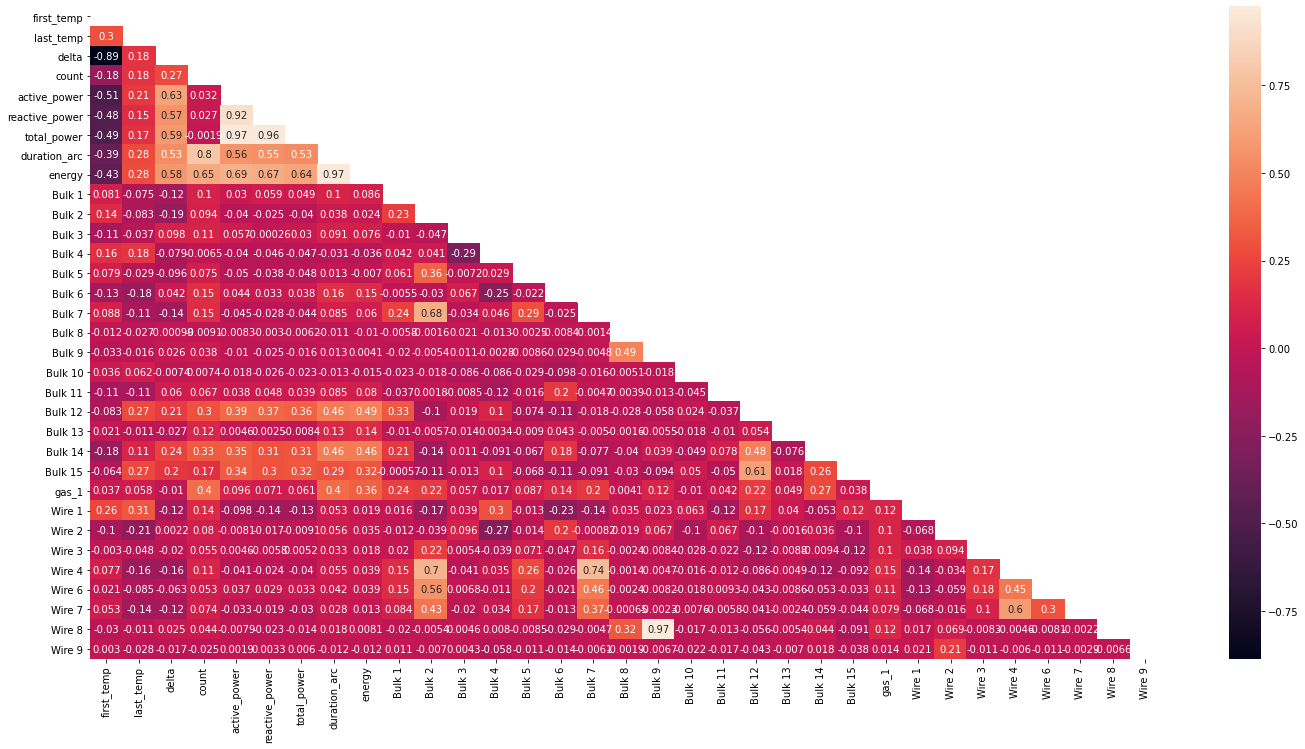

In [27]:
fig, ax = plt.subplots(figsize=(24, 12))
data_corr = data_full.drop(columns=['key']).corr()
sns.heatmap(data_corr, ax=ax, annot=True, mask=np.triu(np.ones_like(data_corr, dtype=bool))) 

Заметим очень высокую связь
* между  Bulk 9 и Wire 8б, 
* между active_power, reactive_power, total_power, 
* между duration_arc и energy


Рассмотрим подробнее  корреляцию  > 0.9

In [28]:
data_full.corr().unstack()[(data_full.corr().unstack() < 1) & (abs(data_full.corr().unstack()) > 0.9)]

active_power    reactive_power    0.923008
                total_power       0.966721
reactive_power  active_power      0.923008
                total_power       0.963325
total_power     active_power      0.966721
                reactive_power    0.963325
duration_arc    energy            0.967293
energy          duration_arc      0.967293
Bulk 9          Wire 8            0.974966
Wire 8          Bulk 9            0.974966
dtype: float64

Заметим что очень большая корреляция у Bulk 9 и Wire 8, скорее всего это связанно с технологичесим процессом. 


Большая корелляция между active_power,    reactive_power,    total_power. Удалим total_power и  reactive_power.

Большая корреляция между duration_arc  и  energy. Удалим duration_arc 

Заметим, что факторов по отдельности сильно коррелирующих с таргетом нет. 
Удалим 'delta', так как при добавлении delta к first_temp мы получим last_temp

Удалим столбцы с датами и столбец 'key'

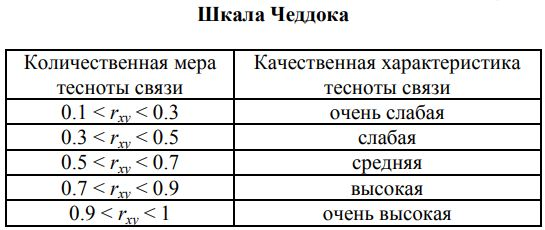

In [29]:
data_full=data_full.drop(columns=['delta', 'total_power', 'duration_arc','reactive_power'])

In [30]:
data_full=data_full.drop(columns=['time_first', 'time_last', 'start_arc_heating', 'end_arc_heating', 'key'])

## Обучение модели

Разобьем данные на train и test к соотношению 80/20. 


* MAE > 8.7 — 0 sp
*   	7.6 < MAE ≤ 8.7 — 4 sp
*   	6.8 < MAE ≤ 7.6 — 4.5 sp
*   	6.3 < MAE ≤ 6.8 — 5 sp
*   	6.0 < MAE ≤ 6.3 — 5.5 sp
*   	MAE ≤ 6.0 — 6 sp

In [31]:
RNS = 12092022
CV=7


In [32]:
features = data_full.drop('last_temp', axis=1)
target = data_full['last_temp']

features_train, features_test, target_train, target_test = train_test_split(
                                                            features, 
                                                            target, 
                                                            test_size=0.20, 
                                                            random_state=RNS)

Промасштабируем данные

In [33]:
scaler = StandardScaler()
features_train_st = scaler.fit_transform(features_train)
features_train_st = pd.DataFrame(features_train_st, columns=features_train.columns)

In [34]:
features_test_st=scaler.transform(features_test)
features_test_st = pd.DataFrame(features_test_st, columns=features_test.columns)

In [35]:
display(features_test_st.shape, features_train_st.shape)

(458, 28)

(1831, 28)

In [36]:
display(features_test_st, features_train_st)

,first_temp,count,active_power,energy,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,Bulk 15,gas_1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
0,-0.410180,-0.420731,0.589799,-0.124792,-0.270130,-0.073684,-0.625397,-0.651632,-0.123541,-0.402990,...,-0.220758,-0.902074,0.823613,0.156470,-0.113654,-0.059548,-0.110114,-0.028708,-0.05813,-0.085544
1,-0.922108,-1.038500,1.512474,-0.081892,-0.270130,-0.073684,-0.625397,2.483272,-0.123541,-0.402990,...,0.720464,-0.498286,1.489855,-0.518668,-0.113654,-0.059548,-0.110114,-0.028708,-0.05813,-0.085544
2,0.912299,0.814807,-1.251143,-0.555531,-0.270130,-0.073684,-0.625397,-0.651632,-0.123541,1.182397,...,-0.185462,-0.047321,0.366817,-0.518668,-0.113654,-0.059548,-0.110114,-0.028708,-0.05813,-0.085544
3,-1.178071,0.197038,-0.093989,0.038935,-0.270130,-0.073684,-0.239078,-0.651632,-0.123541,1.763705,...,-0.208993,-0.187122,-0.692018,0.809488,-0.113654,-0.059548,-0.110114,-0.028708,-0.05813,-0.085544
4,0.997620,1.432576,-0.370772,0.502517,-0.270130,-0.073684,-0.625397,1.478059,-0.123541,-0.402990,...,0.967535,0.105405,0.432381,-0.518668,-0.113654,-0.059548,-0.110114,-0.028708,-0.05813,-0.085544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
453,-0.708805,-0.420731,-0.890179,-0.651081,-0.270130,-0.073684,0.973163,-0.651632,-0.123541,-0.402990,...,-1.432581,-0.954739,-1.888143,0.070640,-0.113654,-0.059548,-0.110114,-0.028708,-0.05813,-0.085544
454,0.613675,0.197038,0.152174,0.715533,2.271785,-0.073684,-0.625397,-0.651632,-0.123541,-0.402990,...,-1.432581,0.673653,-0.278071,-0.518668,-0.113654,-0.059548,-0.110114,-0.028708,-0.05813,-0.085544
455,0.698996,-0.420731,-0.217934,-0.276841,-0.270130,-0.073684,-0.625397,2.994398,-0.123541,-0.402990,...,0.391036,-0.129619,-0.482286,-0.518668,-0.113654,-0.059548,-0.110114,-0.028708,-0.05813,-0.085544
456,-0.751465,0.197038,-0.071245,-0.006147,-0.270130,-0.073684,-0.625397,-0.651632,-0.123541,0.565858,...,-0.161932,-0.316366,-0.166362,-0.518668,-0.113654,-0.059548,-0.110114,-0.028708,-0.05813,-0.085544


,first_temp,count,active_power,energy,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,Bulk 15,gas_1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
0,-1.434035,1.432576,3.213626,3.872266,-0.270130,-0.073684,-0.625397,3.488486,-0.123541,-0.402990,...,0.979300,0.808285,0.433456,-0.518668,-0.113654,-0.059548,-0.110114,-0.028708,-0.05813,-0.085544
1,0.826978,-0.420731,-0.254545,-0.529232,-0.270130,-0.073684,0.267132,-0.651632,-0.123541,-0.402990,...,0.555750,-0.774239,-0.372010,-0.518668,-0.113654,-0.059548,-0.110114,-0.028708,-0.05813,-0.085544
2,-1.519356,0.197038,1.234946,0.718077,-0.270130,-0.073684,-0.625397,3.420336,-0.123541,-0.402990,...,-0.220758,-0.459438,-0.140495,-0.518668,-0.113654,-0.059548,-0.110114,-0.028708,-0.05813,-0.085544
3,0.059086,0.814807,0.521343,0.715456,2.107791,-0.073684,-0.625397,-0.651632,-0.123541,1.129551,...,0.979300,-1.588243,-1.427334,-0.518668,-0.113654,-0.059548,-0.110114,-0.028708,-0.05813,-0.085544
4,0.016426,0.197038,1.328303,1.221129,-0.270130,-0.073684,1.426089,-0.651632,-0.123541,3.225784,...,-1.432581,0.237145,0.292655,5.801797,-0.113654,-0.059548,-0.110114,-0.028708,-0.05813,-0.085544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1826,0.229729,0.197038,0.312413,0.701112,-0.270130,-0.073684,3.837251,-0.651632,-0.123541,-0.402990,...,0.402802,3.374292,-0.164141,-0.518668,-0.113654,-0.059548,-0.110114,-0.028708,-0.05813,-0.085544
1827,-1.348714,0.814807,-0.663413,0.216403,-0.270130,-0.073684,-0.625397,-0.651632,-0.123541,-0.402990,...,0.379271,0.200582,-0.278071,0.746664,-0.113654,-0.059548,-0.110114,-0.028708,-0.05813,-0.085544
1828,0.443032,-0.420731,0.314104,-0.305021,-0.270130,-0.073684,-0.625397,1.137308,-0.123541,-0.402990,...,1.214606,-0.448400,0.870906,-0.518668,-0.113654,-0.059548,-0.110114,-0.028708,-0.05813,-0.085544
1829,1.253584,0.197038,-0.030872,0.278346,-0.270130,-0.073684,-0.625397,-0.651632,-0.123541,2.256937,...,0.979300,2.010564,-0.784308,-0.518668,-0.113654,-0.059548,-0.110114,-0.028708,-0.05813,-0.085544


### LinearRegression

In [37]:
%%time

model_LR = LinearRegression()
MAE_LR = (cross_val_score(model_LR, 
                             features_train_st, 
                             target_train, 
                             cv=CV, 
                             scoring='neg_mean_absolute_error').mean() * -1)
MAE_LR

CPU times: user 128 ms, sys: 246 ms, total: 375 ms
Wall time: 340 ms


6.346809488422073

### RandomForestRegressor

In [38]:
%%time
model_RF = RandomForestRegressor()
params = [{'criterion':['mse'],
                'n_estimators':[x for x in range(100, 500, 50)], 
                'random_state':[RNS]}]
clf = GridSearchCV(model_RF, params, scoring='neg_mean_absolute_error', cv=CV)
clf.fit(features_train_st, target_train)
best_params=clf.best_params_
best_params


CPU times: user 2min 50s, sys: 891 ms, total: 2min 51s
Wall time: 2min 51s


{'criterion': 'mse', 'n_estimators': 400, 'random_state': 12092022}

In [39]:
%%time
model_RF = RandomForestRegressor(criterion='mse', n_estimators=best_params['n_estimators'], random_state=RNS)
MAE_RF = (cross_val_score(model_RF, 
                             features_train_st, 
                             target_train, 
                             cv=CV, 
                             scoring='neg_mean_absolute_error').mean() * -1)

CPU times: user 29.4 s, sys: 396 ms, total: 29.8 s
Wall time: 29.8 s


In [40]:
MAE_RF

6.108197285626544

### CatBoostRegressor

In [41]:
%%time
clf = CatBoostRegressor(verbose=False, random_state=RNS)
params = [{'iterations': [x for x in [500, 1000]], 
           'depth': [x for x in [3, 6 , 9]]}]

clf_grid = GridSearchCV(clf, params, scoring='neg_mean_absolute_error', cv=CV)

clf_grid.fit(features_train_st, target_train)
best_param = clf_grid.best_params_
best_param



CPU times: user 4min 40s, sys: 4.16 s, total: 4min 44s
Wall time: 5min 35s


{'depth': 6, 'iterations': 1000}

In [42]:
%%time
model_CBR = CatBoostRegressor(verbose=False, random_state=RNS,
                           iterations=best_param['iterations'],
                           depth=best_param['depth']
                          )

CPU times: user 72 µs, sys: 1 µs, total: 73 µs
Wall time: 77.5 µs


In [43]:
MAE_CBR = (cross_val_score(model_CBR, 
                             features_train_st, 
                             target_train, 
                             cv=CV, 
                             scoring='neg_mean_absolute_error').mean() * -1)
MAE_CBR

5.972084260867315

### XGBRegressor

In [44]:
%%time
model_XGBR = XGBRegressor(random_state=RNS)

CPU times: user 45 µs, sys: 1 µs, total: 46 µs
Wall time: 50.5 µs


In [45]:
MAE_XGBR = (cross_val_score(model_XGBR, 
                             features_train_st, 
                             target_train, 
                             cv=CV, 
                             scoring='neg_mean_absolute_error').mean() * -1)
MAE_XGBR

6.308343290037947

### Выбор лучшей модели

In [46]:
index = ['LinearRegression',
         'RandomForestRegressor',
         'CatBoostRegressor',
         'XGBRegressor']
data = {'MAE':[ MAE_LR,
                MAE_RF,
                MAE_CBR,
                MAE_XGBR]}
df = pd.DataFrame(data=data, index=index)
df

,MAE
LinearRegression,6.346809
RandomForestRegressor,6.108197
CatBoostRegressor,5.972084
XGBRegressor,6.308343


Лучшая модель по MAE -  CatBoostRegressor

## Проверка на тестовой выборке 

In [47]:
%%time
model = model_CBR
model.fit(features_train_st, target_train)
target_predict = model.predict(features_test_st)

CPU times: user 3.85 s, sys: 72.4 ms, total: 3.93 s
Wall time: 4.73 s


In [48]:
test_MAE = mean_absolute_error(target_predict, target_test)
test_MAE

5.751294191148131

модель CatBoostRegressor

MAE на тестовой 5.75

## Определение значимых параметров

In [49]:
feature_importances = pd.DataFrame({'feature':features_train_st.columns, 
                                    'importance':model.feature_importances_}).sort_values(by='importance', ascending=False)

<AxesSubplot:xlabel='importance', ylabel='feature'>

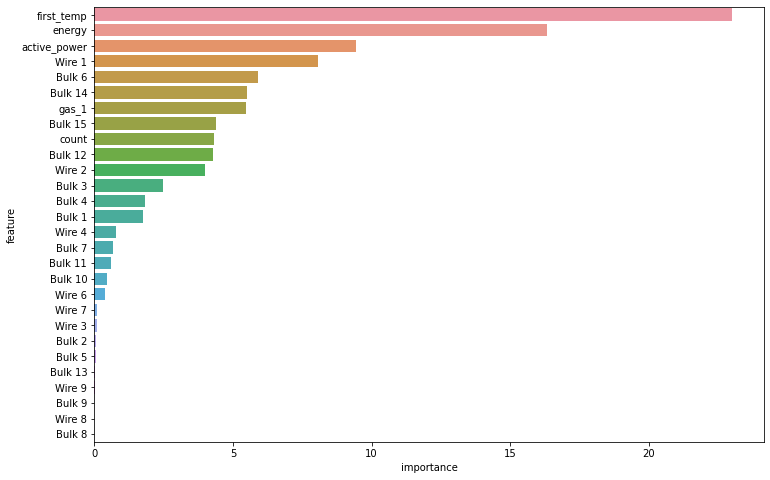

In [50]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(data=feature_importances, y='feature', x='importance', ax=ax)

Наиболее значимые параметры 
* Начальная температура 
* Энергия 

## Общий вывод

Были загруженны данные об этапе обработки стали

***Подготовка и анализ данных***

1. Заполнили пропуски "0" в данных: 

- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` — данные о подаче сыпучих материалов (время);

- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

2. Привели временные данные к типу datetime64[ns] 

3. Вычислили total_power и energy.

4. 
    * Так как температура плавления: 1450—1520 °C, удалили все данные, что меньше 1450.
    * Удалили данные в reactive_power < 0 
    
    * Удалили данные о партиях, где было только первое измерение. 
    * Удалили данные по добавке  "weire 5", так как она использовалась всего один раз   
    
5. Объединили данные в 1 таблицу    
6. Из 3216 партий остались данные по  2289 партиям
7. Исследовали корреляцию признаков. 
     * Прямой зависимости таргета от признаков не выявлено.
     * Заметили что очень высокая корреляция у Bulk 9 и Wire 8, скорее всего это связанно с технологичесим процессом, оставили эти данные.
     * Выявили большую корелляция между active_power,    reactive_power,    total_power. Удалили total_power и  reactive_power.
     * Большая корреляция между duration_arc  и  energy. Удалим duration_arc 


***Построение модели*** 
Построили несколько моделей, которые  предскажут температуру стали, 
С потбором гиперпараметров 

Расчитали с МАЕ

1. LinearRegression	         6.346809
2. RandomForestRegressor	 6.108197
3. CatBoostRegressor	     5.972084
4. XGBRegressor	             6.308343

Лучшие результаты МАЕ у модели ***CatBoostRegressor с параметрами `{'depth': 6, 'iterations': 1000}`***


***MAE c CV 5.97***


У модели CatBoostRegressor    
***MAE на тестовой 5.75***

***Определили, что 
наиболее значимые параметрами для определния температуры являются:***


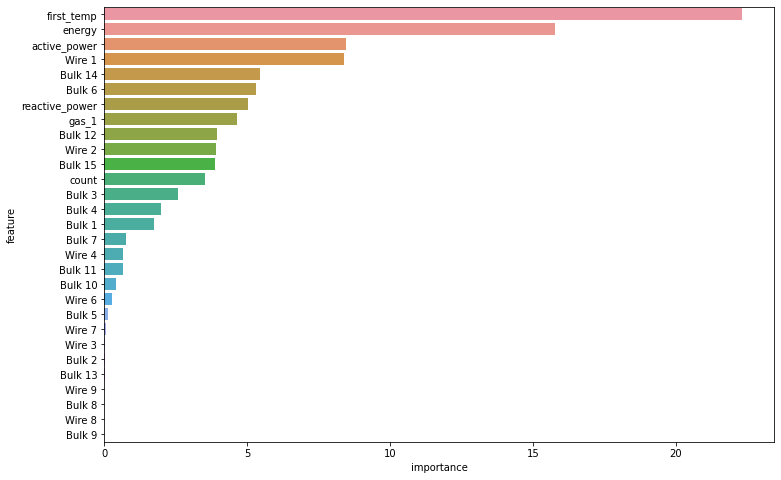


1. ***Начальная температура***

2. ***Энергия***


1. Какие пункты плана были выполнены, а какие — нет (поясните почему)?

Все пункты плана были выполнены


2. Какие трудности возникли и как вы их преодолели?

Трудность в понимании процесса обработки стали, для более точной обработки данных

3. Какие ключевые шаги в решении задачи выделили?

Правильно подготовить данные. 

5. Какая ваша итоговая модель и какое у неё качество?

Лучшие результаты МАЕ у модели CatBoostRegressor
5.97

У модели CatBoostRegressor 
MAE на тестовой 5.75 
